## 매 시도마다 돌릴 것들

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install datasets --quiet

import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

data_path = '/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/data/'  # 이미지 및 텍스트 파일 폴더

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from collections import Counter
from tqdm import tqdm
from collections import Counter
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoConfig
from scipy.special import softmax
import shutil
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import seaborn as sns
import torch.nn as nn
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoProcessor, BlipForConditionalGeneration

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## 전처리

In [2]:
# 텍스트 데이터 로드
texts_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/texts.csv', encoding='unicode_escape')
label_txt = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/label.txt', sep='\t', header=0)
label_txt.columns = ['ID', 'Annotator1', 'Annotator2', 'Annotator3']
label_jpg = label_txt.copy()

def pre_text(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

texts_df['Text'] = texts_df['Text'].apply(pre_text)

In [3]:
dic = {'positive': 1, 'neutral':0, 'negative': -1}
def pre_labeltext(text):
    new_text = text.split(",")[0]
    return dic[new_text]
label_txt['Annotator1'] = label_txt['Annotator1'].apply(pre_labeltext)
label_txt['Annotator2'] = label_txt['Annotator2'].apply(pre_labeltext)
label_txt['Annotator3'] = label_txt['Annotator3'].apply(pre_labeltext)
label_txt['label'] = label_txt['Annotator1'] + label_txt['Annotator2'] + label_txt['Annotator3']
label_txt['label'] = label_txt['label']/3
label_txt = label_txt.drop(['Annotator1', 'Annotator2', 'Annotator3'], axis=1)

In [4]:
def pre_labeltext(text):
    new_text = text.split(",")[1]
    return dic[new_text]
label_jpg['Annotator1'] = label_jpg['Annotator1'].apply(pre_labeltext)
label_jpg['Annotator2'] = label_jpg['Annotator2'].apply(pre_labeltext)
label_jpg['Annotator3'] = label_jpg['Annotator3'].apply(pre_labeltext)
label_jpg['label'] = label_jpg['Annotator1'] + label_jpg['Annotator2'] + label_jpg['Annotator3']
label_jpg['label'] = label_jpg['label']/3
label_jpg = label_jpg.drop(['Annotator1', 'Annotator2', 'Annotator3'], axis=1)

In [5]:
# 라벨 데이터와 텍스트 데이터 병합
merged_text = pd.merge(label_txt, texts_df, on='ID')

## 데이터 라벨링-모델 일치율 확인(만족스럽다)

In [6]:
def checksentiment(listtexts, listlabels):
    MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)
    model.to(device)
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    config = AutoConfig.from_pretrained(MODEL)
    batch_size = 16
    sentiment_scores = []

    for i in tqdm(range(0, len(listtexts), batch_size)):
        batch_texts = listtexts[i:i+batch_size]
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')
        encoded_input.to(device)

        with torch.no_grad():
            outputs = model(**encoded_input)

        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        scores = probabilities.cpu().numpy()

        pos_probs = scores[:, 2]  # 긍정 확률
        neg_probs = scores[:, 0]  # 부정 확률
        sentiments = pos_probs - neg_probs  # 감성 점수
        sentiment_scores.extend(sentiments)

    listlabels = np.array(listlabels)
    sentiment_scores = np.array(sentiment_scores)

    # L2 Loss
    l2_loss = np.mean((sentiment_scores - listlabels) ** 2)
    print(f"L2 Loss: {l2_loss}")

    return sentiment_scores

In [7]:
lab = merged_text['label'].tolist()
sentiment_scores = checksentiment(merged_text['Text'].tolist(), lab)
check = 0
for i in range(len(sentiment_scores)):
    if sentiment_scores[i] * lab[i] < 0:
        check+=1
check

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

100%|██████████| 1225/1225 [00:16<00:00, 73.32it/s]

L2 Loss: 0.2285643614866811


1713

## 이미지 설명-감성 분석 점수 확인(학습 전 저성능 확인)

In [8]:

#자기 전에 켜 둘 것
source_dir = '/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/data'

target_dir = '/content/data'

# 대상 폴더가 없으면 생성
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

loader = label_txt['ID'].tolist()

for filename in tqdm(loader):
    filename_with_ext = f"{filename}.jpg"
    src_file = os.path.join(source_dir, filename_with_ext)
    dst_file = os.path.join(target_dir, filename_with_ext)

    try:
        shutil.copy2(src_file, dst_file)
    except Exception as e:
        print(f"파일 복사 중 오류 발생: {filename_with_ext}, 오류: {e}")


100%|██████████| 19598/19598 [1:11:18<00:00,  4.58it/s]


In [9]:
merged = merged_text

In [10]:
merged = pd.merge(merged, label_txt, on='ID')

In [11]:
merged = pd.merge(merged, label_jpg, on='ID')

In [12]:
scores = np.array(sentiment_scores)
sim = merged['label_x'] * merged['label_y'] > 0
merged['pred'] = scores
input_df = merged[sim]

In [13]:
input_df.drop([1336], axis=0, inplace=True)

<ipython-input-13-a5e798a59b6a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df.drop([1336], axis=0, inplace=True)


In [14]:
input_df.drop([623], axis=0, inplace=True)

<ipython-input-14-ae4d4e9167ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df.drop([623], axis=0, inplace=True)


In [15]:
input_df.drop([12183], axis=0, inplace=True)

<ipython-input-15-43ba43229927>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df.drop([12183], axis=0, inplace=True)


In [16]:
image_dir = '/content/data'
def jpg(num):
    return f"/content/data/{num}.jpg"
input_df['ID'] = input_df['ID'].apply(jpg)

<ipython-input-16-30bbe245632d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['ID'] = input_df['ID'].apply(jpg)


In [17]:
input_df = input_df.astype({'ID':'str'})

In [18]:
input_df = input_df.drop('label_y', axis=1)
input_df = input_df.drop('Unnamed: 2', axis=1)
input_df = input_df.drop('label', axis=1)

In [19]:
train_dataframe, temp = train_test_split(input_df, test_size=0.2, stratify=input_df['label_x'])
val_dataframe, test_dataframe = train_test_split(temp, test_size=0.5, stratify=temp['label_x'])

In [20]:
train_dataframe = train_dataframe.reset_index(drop=True)
val_dataframe = val_dataframe.reset_index(drop=True)
test_dataframe = test_dataframe.reset_index(drop=True)

In [21]:
train_dataframe['Text'][0]

'Because peeing where you like should be in Charter! #cdnpoli'

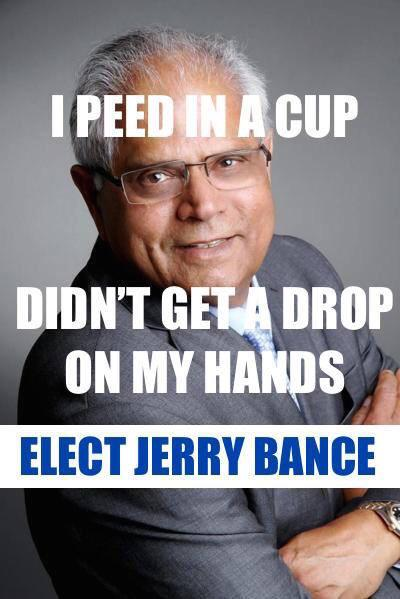

In [22]:
Image.open(train_dataframe['ID'][0]).convert("RGB")

## fine tuning

In [23]:
from PIL import Image
train_dataset = []
for _, row in tqdm(train_dataframe.iterrows()):
    image_path = row["ID"]
    text = row["Text"]

    try:
        image = Image.open(image_path).convert("RGB")  # 이미지 로드
        train_dataset.append({"image": image, "text": text})  # 이미지와 텍스트 저장
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")

# 데이터 확인
print("Dataset length:", len(train_dataset))
print("Sample data:", train_dataset[0])

5441it [00:15, 354.75it/s]

Error loading image /content/data/15324.jpg: image file is truncated (4 bytes not processed)


12652it [00:35, 360.10it/s]

Dataset length: 12651
Sample data: {'image': <PIL.Image.Image image mode=RGB size=400x599 at 0x7AF52518EA40>, 'text': 'Because peeing where you like should be in Charter! #cdnpoli'}


In [24]:
val_dataset = []
for _, row in tqdm(val_dataframe.iterrows()):
    image_path = row["ID"]
    text = row["Text"]

    try:
        image = Image.open(image_path).convert("RGB")  # 이미지 로드
        val_dataset.append({"image": image, "text": text})  # 이미지와 텍스트 저장
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")

# 데이터 확인
print("Dataset length:", len(val_dataset))
print("Sample data:", val_dataset[0])

1582it [00:04, 364.72it/s]

Dataset length: 1582
Sample data: {'image': <PIL.Image.Image image mode=RGB size=600x800 at 0x7AF52C2E2620>, 'text': 'Last nights fun times @user #janetjackson #UnbreakableToronto'}


In [25]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [26]:
from transformers import AutoProcessor, BlipForConditionalGeneration
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [27]:
train = ImageCaptioningDataset(train_dataset, processor)
train_dataloader = DataLoader(train, shuffle=False, batch_size=8)

In [28]:
val = ImageCaptioningDataset(val_dataset, processor)
val_dataloader = DataLoader(val, shuffle=False, batch_size=8)

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [30]:
output = model.generate(**processor(train_dataset[0]['image'], return_tensors="pt"))
captions = [processor.decode(output[0], skip_special_tokens=True)]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [31]:
captions

['a man in a suit and tie with his arms crossed']

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

model.to(device)

In [77]:
len(val_dataloader)

198

In [33]:
trainlosscheck = []
vallosscheck = []

In [ ]:
model.to(device)

In [73]:
for epoch in range(5):
    model.train()
    total_loss = 0
    print("Epoch:", epoch)
    for idx, batch in enumerate(tqdm(train_dataloader)):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        trainlosscheck.append(loss.to('cpu').item())
    print('train loss:', total_loss)


    model.eval()
    total_loss = 0
    print("Epoch:", epoch)
    for idx, batch in enumerate(tqdm(val_dataloader)):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)

        loss = outputs.loss.to('cpu').item()
        vallosscheck.append(loss)
        vallosscheck.append(loss)
        vallosscheck.append(loss)
        total_loss += loss

    print('val loss:', total_loss)
    torch.cuda.empty_cache()


Epoch: 0


100%|██████████| 1582/1582 [16:20<00:00,  1.61it/s]


train loss: 254.83735934644938
Epoch: 0


100%|██████████| 198/198 [00:52<00:00,  3.77it/s]


val loss: 35.28741916269064
Epoch: 1


100%|██████████| 1582/1582 [16:20<00:00,  1.61it/s]


train loss: 484.7969024479389
Epoch: 1


100%|██████████| 198/198 [00:52<00:00,  3.78it/s]


val loss: 98.4132210612297
Epoch: 2


100%|██████████| 1582/1582 [16:21<00:00,  1.61it/s]


train loss: 783.0966964662075
Epoch: 2


100%|██████████| 198/198 [00:52<00:00,  3.78it/s]


val loss: 98.44701799750328
Epoch: 3


100%|██████████| 1582/1582 [16:20<00:00,  1.61it/s]


train loss: 781.2689070999622
Epoch: 3


100%|██████████| 198/198 [00:52<00:00,  3.78it/s]


val loss: 98.27607542276382
Epoch: 4


100%|██████████| 1582/1582 [16:21<00:00,  1.61it/s]


train loss: 784.1815834641457
Epoch: 4


100%|██████████| 198/198 [00:52<00:00,  3.78it/s]


val loss: 98.22724333405495


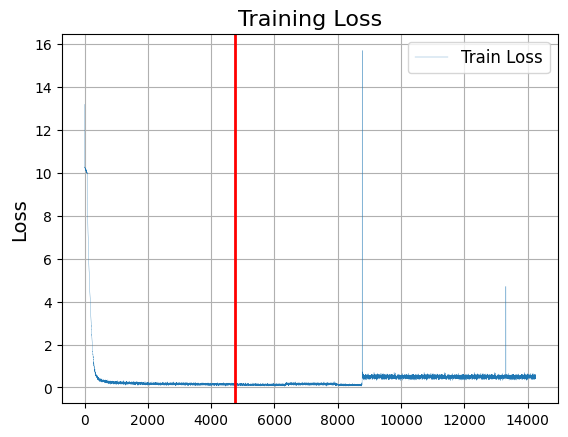

In [80]:
plt.figure()
epochs = range(1, len(trainlosscheck) + 1)
plt.plot(epochs, trainlosscheck, label="Train Loss", linestyle="-", linewidth=0.2)

# 그래프 설정
plt.title("Training Loss", fontsize=16)
plt.axvline(4746, 0, 1, color='red', linestyle='-', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

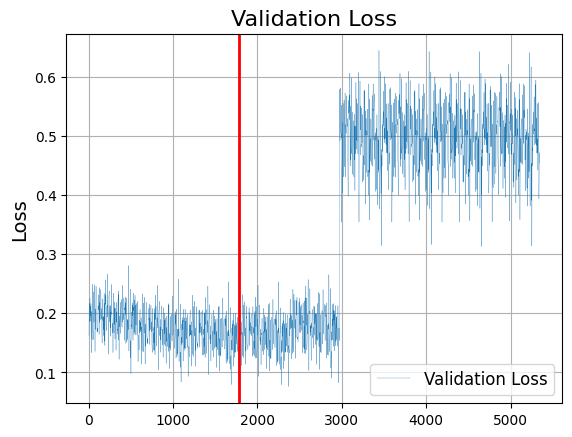

In [81]:
epochs = range(1, len(vallosscheck) + 1)
plt.plot(epochs, vallosscheck, label="Validation Loss", linestyle="-", linewidth=0.2)
plt.title("Validation Loss", fontsize=16)
plt.axvline(1782, 0, 1, color='red', linestyle='-', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

In [37]:
model.to('cpu')
output = model.generate(**processor(train_dataset[0]['image'], return_tensors="pt"))
captions = [processor.decode(output[0], skip_special_tokens=True)]

In [38]:
captions

['# cdnpoli # elxn42 # cdnpoli # elxn2015']

## 결과 확인

In [39]:
# 감성 분석 모델 로드 (고정된 상태로 사용)
MODEL_SA = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer_sa = AutoTokenizer.from_pretrained(MODEL_SA)
config_sa = AutoConfig.from_pretrained(MODEL_SA)
model_sa = AutoModelForSequenceClassification.from_pretrained(MODEL_SA)
model_sa.to(device)
model_sa.eval()  # 평가 모드

# 감성 분석 모델의 파라미터를 고정
for param in model_sa.parameters():
    param.requires_grad = False

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
# 손실 함수 정의 (예: MSELoss)
criterion = nn.MSELoss()

# 옵티마이저 정의 (BLIP 모델의 파라미터만 업데이트)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [41]:
num_epochs = 100  # 최대 에포크 수를 크게 설정
patience = 5      # 검증 손실이 개선되지 않는 에포크 수 허용치
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

In [42]:
class ImageDataset(Dataset):
    def __init__(self, image_ids, labels, image_dir, processor):
        self.image_ids = image_ids
        self.labels = labels
        self.image_dir = image_dir
        self.processor = processor

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_ids[idx])
        image = Image.open(image_path).convert('RGB')
        # 이미지 전처리 수행
        pix = self.processor(image, return_tensors='pt')
        # 배치 차원 제거 (processor는 보통 배치 차원을 포함하여 반환)
        pix = {k: v.squeeze(0) for k, v in pix.items()}
        label = self.labels[idx]
        return pix, label

# 데이터셋과 데이터로더 생성
test_id = test_dataframe['ID'].tolist()
test_label = test_dataframe['pred'].tolist()
test_dataset = ImageDataset(test_id, test_label, image_dir, processor)

batch_size = 8  # 적절한 배치 사이즈 설정
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [44]:
model.to(device)
model.eval()
total_loss = 0
for batch in tqdm(test_dataloader):
    pix, labels = batch
    pix = {k: v.to(device) for k, v in pix.items()}
    labels = labels.to('cpu')
    # BLIP 모델을 통해 캡션 생성
    outputs = model.generate(**pix)
    # 생성된 토큰 ID를 디코딩하여 텍스트로 변환
    captions = [processor.decode(output, skip_special_tokens=True) for output in outputs]

    # 감성 분석 모델을 통해 감성 점수 계산
    inputs_sa = tokenizer_sa(captions, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs_sa = model_sa(**inputs_sa)
    scores = outputs_sa.logits.cpu().numpy()
    probs = softmax(scores, axis=1)
    pos_probs = probs[:, 2]  # 긍정 확률 (모델에 따라 인덱스 확인 필요)
    neg_probs = probs[:, 0]  # 부정 확률
    sentiment_scores = pos_probs - neg_probs  # [batch_size]
    total_abs_diff_sum = sum(torch.abs(tensor - torch.tensor(numpy)).item()
                         for tensor, numpy in zip(labels, sentiment_scores))
    total_loss += total_abs_diff_sum

avg_loss = total_loss / len(test_dataloader)
print(f"Loss: {avg_loss:.4f}")

100%|██████████| 198/198 [01:48<00:00,  1.83it/s]

Loss: 3.7478


In [50]:
model.to(device)
model.eval()
total_acc = []
for batch in tqdm(test_dataloader):
    pix, labels = batch
    pix = {k: v.to(device) for k, v in pix.items()}
    labels = labels.to('cpu')
    # BLIP 모델을 통해 캡션 생성
    outputs = model.generate(**pix)
    # 생성된 토큰 ID를 디코딩하여 텍스트로 변환
    captions = [processor.decode(output, skip_special_tokens=True) for output in outputs]

    # 감성 분석 모델을 통해 감성 점수 계산
    inputs_sa = tokenizer_sa(captions, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs_sa = model_sa(**inputs_sa)
    scores = outputs_sa.logits.cpu().numpy()
    probs = softmax(scores, axis=1)
    pos_probs = probs[:, 2]  # 긍정 확률 (모델에 따라 인덱스 확인 필요)
    neg_probs = probs[:, 0]  # 부정 확률
    sentiment_scores = pos_probs - neg_probs  # [batch_size]
    result = [t.item() * n for t, n in zip(labels, sentiment_scores)]
    total_acc.extend(result)

count = 0
for i in total_acc:
    if i < 0:
        count+=1
print(count/len(total_acc))

  0%|          | 0/198 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 198/198 [01:48<00:00,  1.82it/s]

0.1554993678887484


## 비교군

In [45]:
model_compare = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
model_compare.to(device)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [51]:
model_compare.to(device)
model_compare.eval()
total_acc = []
for batch in tqdm(test_dataloader):
    pix, labels = batch
    pix = {k: v.to(device) for k, v in pix.items()}
    labels = labels.to('cpu')
    # BLIP 모델을 통해 캡션 생성
    outputs = model_compare.generate(**pix)
    # 생성된 토큰 ID를 디코딩하여 텍스트로 변환
    captions = [processor.decode(output, skip_special_tokens=True) for output in outputs]

    # 감성 분석 모델을 통해 감성 점수 계산
    inputs_sa = tokenizer_sa(captions, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs_sa = model_sa(**inputs_sa)
    scores = outputs_sa.logits.cpu().numpy()
    probs = softmax(scores, axis=1)
    pos_probs = probs[:, 2]  # 긍정 확률 (모델에 따라 인덱스 확인 필요)
    neg_probs = probs[:, 0]  # 부정 확률
    sentiment_scores = pos_probs - neg_probs  # [batch_size]
    result = [t.item() * n for t, n in zip(labels, sentiment_scores)]
    total_acc.extend(result)

count = 0
for i in total_acc:
    if i < 0:
        count+=1
print(count/len(total_acc))

  0%|          | 0/198 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 198/198 [01:34<00:00,  2.10it/s]

0.3786346396965866


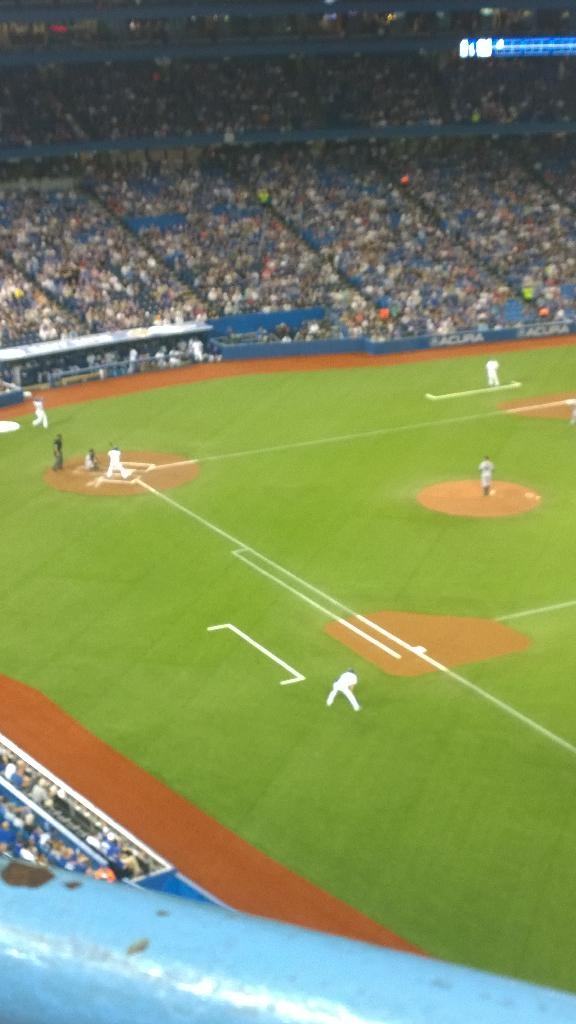

In [66]:
train_dataset[11]['image']

In [65]:
train_dataset[11]['text']

"Can't complain about the 500 level when you have 1st row ?? @user #BlueJays"

In [67]:
output = model_compare.generate(**processor(train_dataset[11]['image'], return_tensors="pt"))
captions = [processor.decode(output[0], skip_special_tokens=True)]
captions

['a baseball game is being played in a stadium']

In [68]:
output = model.generate(**processor(train_dataset[11]['image'], return_tensors="pt"))
captions = [processor.decode(output[0], skip_special_tokens=True)]
captions

['# bluejays vs # tigers # cometogether']

## 저장

In [47]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/'
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)

print(f"Model saved to {save_dir}")

Model saved to /content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/


In [48]:
import csv

with open(os.path.join(save_dir, "list_data.csv"), "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(trainlosscheck)
    writer.writerow(vallosscheck)